#Cardiac Evaluate Model PSG-Audio

This version from Resp equivalent 2/6/2023 modified for cardiac classification tuning.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:

* 

# Imports

In [1]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from datetime import timedelta # for calculating training time
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import compute_sample_weight
import sys
import urllib.request # to get files from web w/o !wget
from shutil import unpack_archive # to unzip

In [2]:
my_dir = '.' # replace with absolute path if desired
interactive = True # runs simple calls for most cells
# verbose = True

working_dir = os.path.join(my_dir,'psg_dataset') # create local directory
if not os.path.exists(working_dir):
    os.mkdir(working_dir)

# Get small or full processed PSG-Audio numpy arrays
See PSG-Audio_load_dataset_for_multi-output.ipynb for info, this is source of the arrays.


In [3]:
use_small = True # arrays are 1/10th the size for shorter download/train time
if use_small:
    version = "small"
    flist = ["small_x_train.npy", "small_y_train.npy", "small_sub_train.npy"]
else:
    version = "full"
    flist = ["x_train.npy", "y_train.npy", "sub_train.npy"]

In [4]:
# this needs to be per file apparently.
# !gdown.download_folder('https://drive.google.com/drive/folders/10G5SbdPKZWpZSBkO_II8dR4SoOfEJJwz?usp=sharing')

!gdown "1zo_Amyb_vbAL1VKpa1IKtuHpL5Gw9IaG&confirm=t" # small_x_train
!gdown "1_ZFknIBTNaCS7lCILDM0loUOFUUzz8EZ&confirm=t" # small_y_train
!gdown "1KbOqMdPlOUaT1TQMY_NTp-oKqnRzelfb&confirm=t" # small_sub_train
working_dir = "." # just to stay compatible, gdown uses current dir.

Downloading...
From: https://drive.google.com/uc?id=1zo_Amyb_vbAL1VKpa1IKtuHpL5Gw9IaG&confirm=t
To: /content/small_x_train.npy
100% 610M/610M [00:08<00:00, 69.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ZFknIBTNaCS7lCILDM0loUOFUUzz8EZ&confirm=t
To: /content/small_y_train.npy
100% 84.8k/84.8k [00:00<00:00, 92.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KbOqMdPlOUaT1TQMY_NTp-oKqnRzelfb&confirm=t
To: /content/small_sub_train.npy
100% 84.8k/84.8k [00:00<00:00, 76.1MB/s]


In [5]:
def read_arrays():
    """read in the arrays - leaving test arrays out of this for now (just tuning model)"""
    if use_small:
        print("Reading in small arrays")
        X = np.load(os.path.join(working_dir, 'small_x_train.npy'))
        y = np.load(os.path.join(working_dir, 'small_y_train.npy'))
        sub = np.load(os.path.join(working_dir, 'small_sub_train.npy'))
    else:
        print("Reading in full arrays")
        X = np.load(os.path.join(working_dir, 'x_train.npy'))
        y = np.load(os.path.join(working_dir, 'y_train.npy'))
        sub = np.load(os.path.join(working_dir, 'sub_train.npy'))
    print("Reading arrays from npy files")
    headers = ("Array","shape", "data type")
    mydata = [("X:", X.shape, X.dtype),
            ("y:", y.shape, y.dtype),
            ("sub:", sub.shape, sub.dtype)]
    print("\n",tabulate(mydata, headers=headers))
    return X, y, sub
if interactive:
    X, y, sub = read_arrays()

Reading in small arrays
Reading arrays from npy files

 Array    shape             data type
-------  ----------------  -----------
X:       (42333, 300, 12)  float32
y:       (42333, 2)        int8
sub:     (42333, 1)        uint16


# Split X by Signal Modality and y by Event Type

In [6]:
# Seems like it would be better to pass X directly and handle in the model
# but I don't see such a preprocessing method.   Maybe it is more obvious?
# https://keras.io/guides/preprocessing_layers/

X_eeg = X[:,:,0:3] # first 3 channels (0,1,2)
X_eog = X[:,:,3:5] # channels 3 and 4
X_emg = X[:,:,5:6] # just channel 5
X_ecg = X[:,:,8:9] # ECG - this is a goofy way to keep shape w/ one channel...
X_flow = X[:,:,9:10] # ECG - this is a goofy way to keep shape w/ one channel...
X_reff = X[:,:,10:12] # abd, thor respiratory effort

y_card = y[:,0:1] # cardiac events are first column of y
y_resp = y[:,1:2] # respiratory events are second column of y

X_all = [X_eeg, X_eog, X_emg, X_ecg, X_flow, X_reff]
X_all_dict = {'eeg': X_eeg, 'eog':X_eog, 'emg':X_emg, 'ecg':X_ecg, 'flow':X_flow, 'reff':X_reff}
y_all = [y_card, y_resp]
y_all_dict = {'card':y_card,'resp':y_resp}
for key,item in X_all_dict.items():
    print(key,item.shape)
for key, item in y_all_dict.items():
    print(key,item.shape)

eeg (42333, 300, 3)
eog (42333, 300, 2)
emg (42333, 300, 1)
ecg (42333, 300, 1)
flow (42333, 300, 1)
reff (42333, 300, 2)
card (42333, 1)
resp (42333, 1)


In [7]:
unique, counts = np.unique(y_card, return_counts=True)
print("\ny_card label values and counts:\n",str(np.asarray((unique, counts)).T))
class_names_y_card = ['Normal','Abnormal'] # matches _90_10 processed files

unique, counts = np.unique(y_resp, return_counts=True)
print("\ny_resp label values and counts:\n",str(np.asarray((unique, counts)).T))
class_names_y_resp = ['Normal','Apnea','Hypopnea'] # matches _90_10 processed files


y_card label values and counts:
 [[    0 37157]
 [    1  5176]]

y_resp label values and counts:
 [[    0 23252]
 [    1 15479]
 [    2  3602]]


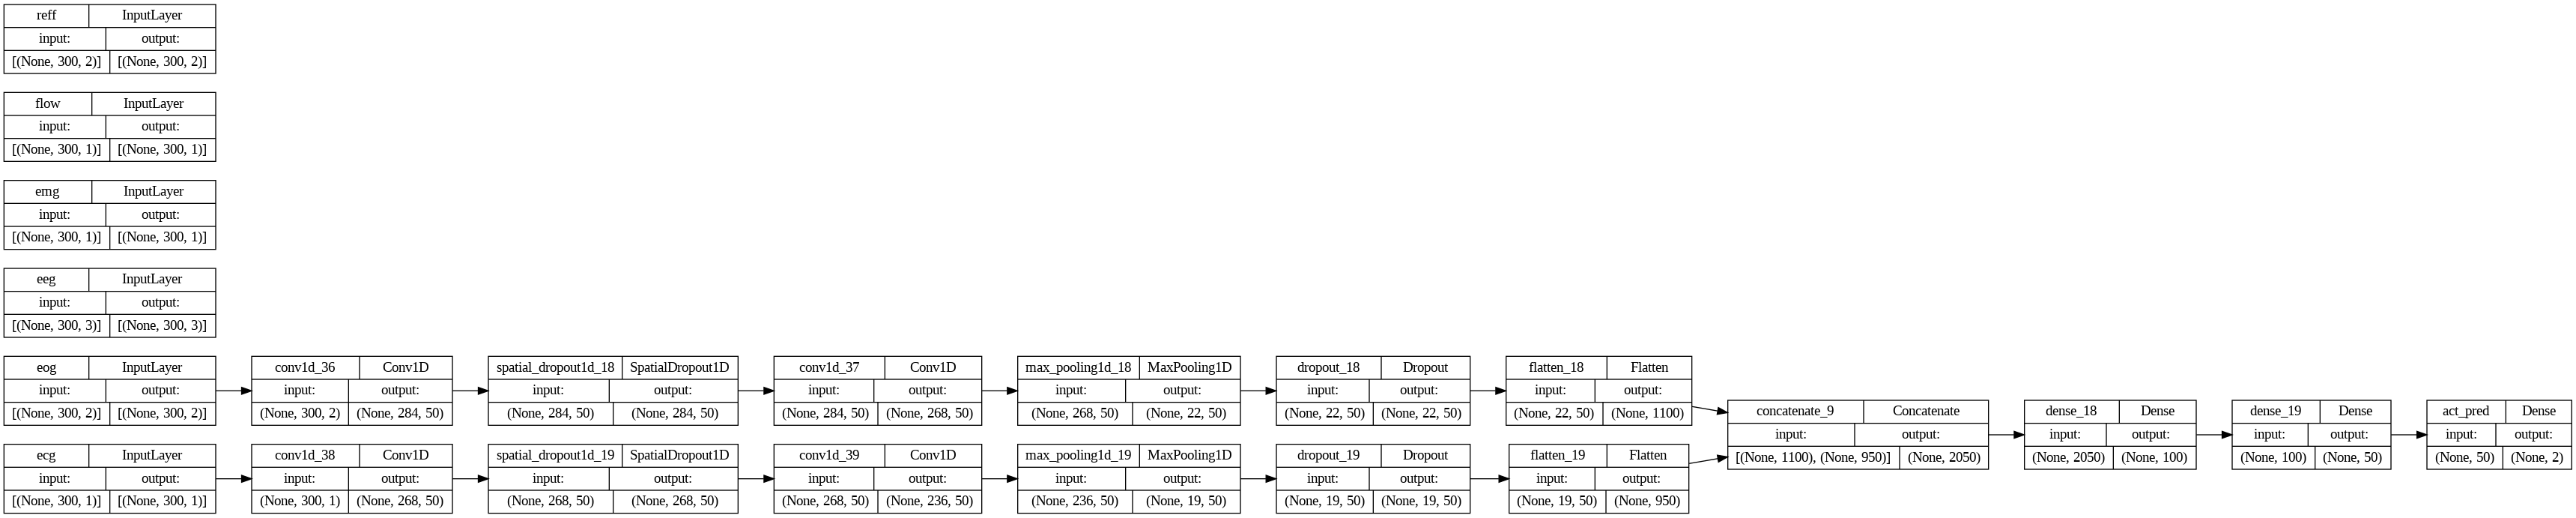

In [16]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# ref for functional model https://keras.io/guides/functional_api/

# keeping all inputs for re-useability - model will decide which to use

def build_model(X_all_dict,y_all_dict):

    # input layers - 1st dim is timesteps, 2nd is features
    # this method give some configurability but lacks error checking.
    eeg_input = keras.Input(shape = (X_all_dict['eeg'].shape[1], X_all_dict['eeg'].shape[2]), name = "eeg")
    eog_input = keras.Input(shape = (X_all_dict['eog'].shape[1], X_all_dict['eog'].shape[2]), name = "eog")
    emg_input = keras.Input(shape = (X_all_dict['emg'].shape[1], X_all_dict['emg'].shape[2]), name = "emg")
    ecg_input = keras.Input(shape = (X_all_dict['ecg'].shape[1], X_all_dict['ecg'].shape[2]), name = "ecg")
    flow_input = keras.Input(shape = (X_all_dict['flow'].shape[1], X_all_dict['flow'].shape[2]), name = "flow")
    reff_input = keras.Input(shape = (X_all_dict['reff'].shape[1], X_all_dict['reff'].shape[2]), name = "reff")

    a = layers.Conv1D(filters=50, kernel_size=17, activation='relu')(eog_input)
    a = layers.SpatialDropout1D(0.25)(a)
    a = layers.Conv1D(filters=50, kernel_size=17, activation='relu')(a)
    a = layers.MaxPooling1D(pool_size=12)(a)
    a = layers.Dropout(0.25)(a)

    b = layers.Conv1D(filters=50, kernel_size=33, activation='relu')(ecg_input)
    b = layers.SpatialDropout1D(0.25)(b)
    b = layers.Conv1D(filters=50, kernel_size=33, activation='relu')(b)
    b = layers.MaxPooling1D(pool_size=12)(b)
    b = layers.Dropout(0.25)(b)

    #merged = layers.Concatenate(axis=1)([c, d]) 
    #merged = layers.GlobalAveragePooling1D()(merged)
    
    a = layers.Flatten()(a) # must pass tensor not as arg
    b = layers.Flatten()(b)

    merged = layers.Concatenate(axis=-1)([a,b])
    merged = layers.Dense(100, activation='relu')(merged)
    merged = layers.Dense(50, activation='relu')(merged)
    
    #n_outputs = y_resp.shape[1] 
    # this is going to be a pain between cardiac and resp until in model!
    n_outputs = 2 # just to test other items - need one-hot in model
    pred = layers.Dense(n_outputs, activation='softmax', name='act_pred')(merged)

    model = keras.Model([eeg_input, eog_input, emg_input, ecg_input, flow_input, reff_input],
                        pred)
    return model
if interactive:
    my_model = build_model(X_all_dict, y_all_dict)
    # model.summary()
    # pass rankdir="LR" to plot_model to display sideways
    display(keras.utils.plot_model(my_model, "my_model.png", show_shapes=True, rankdir = "LR"))


# Define function to train model

In [17]:
def train_model(model, X_train_dict, y_train_resp, X_valid_dict, y_valid_resp,
                BATCH_SIZE = 64, #
                NUM_EPOCHS = 50): # Max number run unless earlystopping callback fires

    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=10)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    sample_weights = compute_sample_weight('balanced', y_train_card)
    sample_weights = np.sqrt(sample_weights) # no idea why weights are squared.
    #print("sample_weights",sample_weights)
    unique, counts = np.unique(sample_weights, return_counts=True)
    #print("sample_weights values and counts:\n",str(np.asarray((unique, counts)).T))
    
    history = model.fit(
        #{"acc": x_train_acc, "bvp": x_train_bvp, "eda": x_train_eda,"ptemp": x_train_ptemp},
        #{"act_pred": y_train},
        {"eeg": X_train_dict['eeg'], "eog": X_train_dict['eog'], "emg": X_train_dict['emg'],
         "ecg": X_train_dict['ecg'], "flow": X_train_dict['flow'], "reff":X_train_dict['reff']},
         {"act_pred": y_train_card},
         #{"y_card":y_train_card, "y_resp":y_train_resp},
        batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        sample_weight=sample_weights,
        validation_data=({"eeg": X_valid_dict['eeg'], "eog": X_valid_dict['eog'], 
                          "emg": X_valid_dict['emg'], "ecg": X_valid_dict['ecg'],
                          "flow": X_valid_dict['flow'], "reff":X_valid_dict['reff']},
                         {"act_pred": y_valid_card}),             
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model

# if (interactive):
#     # Note:  if you rerun this cell it continues to train the existing model
#     history, model = train_4input_CNN_no_val(model, x_train_acc, x_train_bvp,
#                                       x_train_eda, x_train_ptemp ,y_train,NUM_EPOCHS = 100)

## Run a stratified 5-fold group-based cross validation

Fold 0:
Epoch 1/50
542/542 [==============================] - 7s 11ms/step - loss: 1.1606 - accuracy: 0.5238 - val_loss: 0.7079 - val_accuracy: 0.4844
Epoch 2/50
542/542 [==============================] - 5s 10ms/step - loss: 0.6962 - accuracy: 0.5034 - val_loss: 0.6283 - val_accuracy: 0.6282
Epoch 3/50
542/542 [==============================] - 6s 10ms/step - loss: 0.6754 - accuracy: 0.5542 - val_loss: 0.6987 - val_accuracy: 0.5594
Epoch 4/50
542/542 [==============================] - 5s 9ms/step - loss: 0.6500 - accuracy: 0.6341 - val_loss: 0.6112 - val_accuracy: 0.7207
Epoch 5/50
542/542 [==============================] - 5s 10ms/step - loss: 0.6226 - accuracy: 0.6557 - val_loss: 0.6095 - val_accuracy: 0.7548
Epoch 6/50
542/542 [==============================] - 7s 13ms/step - loss: 0.6250 - accuracy: 0.5925 - val_loss: 0.6997 - val_accuracy: 0.4943
Epoch 7/50
542/542 [==============================] - 5s 10ms/step - loss: 0.6105 - accuracy: 0.5685 - val_loss: 0.6374 - val_accuracy:

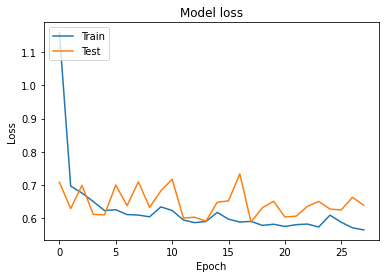

Fold 1:
Epoch 1/50
523/523 [==============================] - 6s 10ms/step - loss: 1.3266 - accuracy: 0.5465 - val_loss: 0.8764 - val_accuracy: 0.3464
Epoch 2/50
523/523 [==============================] - 5s 10ms/step - loss: 0.7333 - accuracy: 0.6055 - val_loss: 0.7259 - val_accuracy: 0.4221
Epoch 3/50
523/523 [==============================] - 5s 9ms/step - loss: 0.6391 - accuracy: 0.6680 - val_loss: 0.5757 - val_accuracy: 0.7908
Epoch 4/50
523/523 [==============================] - 5s 10ms/step - loss: 0.6473 - accuracy: 0.6773 - val_loss: 0.6908 - val_accuracy: 0.6552
Epoch 5/50
523/523 [==============================] - 5s 10ms/step - loss: 0.6397 - accuracy: 0.7183 - val_loss: 0.6605 - val_accuracy: 0.6811
Epoch 6/50
523/523 [==============================] - 5s 10ms/step - loss: 0.6972 - accuracy: 0.7766 - val_loss: 0.6458 - val_accuracy: 0.8292
Epoch 7/50
523/523 [==============================] - 5s 10ms/step - loss: 0.6052 - accuracy: 0.7972 - val_loss: 0.5453 - val_accuracy:

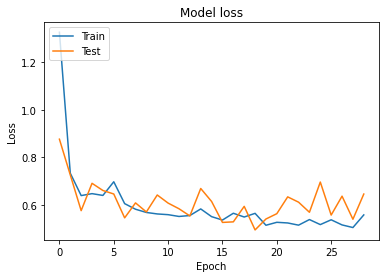

Fold 2:
Epoch 1/50
533/533 [==============================] - 7s 11ms/step - loss: 1.0005 - accuracy: 0.6188 - val_loss: 0.8776 - val_accuracy: 0.4900
Epoch 2/50
533/533 [==============================] - 5s 10ms/step - loss: 0.6336 - accuracy: 0.6855 - val_loss: 0.6818 - val_accuracy: 0.7113
Epoch 3/50
533/533 [==============================] - 5s 10ms/step - loss: 0.6141 - accuracy: 0.7463 - val_loss: 0.8299 - val_accuracy: 0.7115
Epoch 4/50
533/533 [==============================] - 5s 10ms/step - loss: 0.5869 - accuracy: 0.7520 - val_loss: 0.7342 - val_accuracy: 0.7654
Epoch 5/50
533/533 [==============================] - 5s 10ms/step - loss: 0.5892 - accuracy: 0.7579 - val_loss: 0.6972 - val_accuracy: 0.8197
Epoch 6/50
533/533 [==============================] - 5s 10ms/step - loss: 0.5925 - accuracy: 0.7445 - val_loss: 0.6080 - val_accuracy: 0.7845
Epoch 7/50
533/533 [==============================] - 6s 10ms/step - loss: 0.6004 - accuracy: 0.7543 - val_loss: 0.5846 - val_accuracy

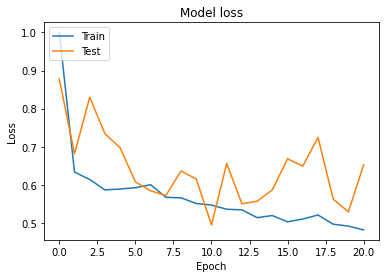

Fold 3:
Epoch 1/50
538/538 [==============================] - 7s 11ms/step - loss: 1.0357 - accuracy: 0.5163 - val_loss: 0.6621 - val_accuracy: 0.6608
Epoch 2/50
538/538 [==============================] - 5s 10ms/step - loss: 0.6950 - accuracy: 0.5126 - val_loss: 0.6871 - val_accuracy: 0.4623
Epoch 3/50
538/538 [==============================] - 5s 9ms/step - loss: 0.7134 - accuracy: 0.5033 - val_loss: 0.6979 - val_accuracy: 0.4527
Epoch 4/50
538/538 [==============================] - 6s 10ms/step - loss: 0.6914 - accuracy: 0.5015 - val_loss: 0.5944 - val_accuracy: 0.7306
Epoch 5/50
538/538 [==============================] - 5s 10ms/step - loss: 0.6730 - accuracy: 0.5447 - val_loss: 0.6679 - val_accuracy: 0.5981
Epoch 6/50
538/538 [==============================] - 5s 10ms/step - loss: 0.6648 - accuracy: 0.5587 - val_loss: 0.5981 - val_accuracy: 0.7415
Epoch 7/50
538/538 [==============================] - 5s 10ms/step - loss: 0.6934 - accuracy: 0.7095 - val_loss: 0.6846 - val_accuracy:

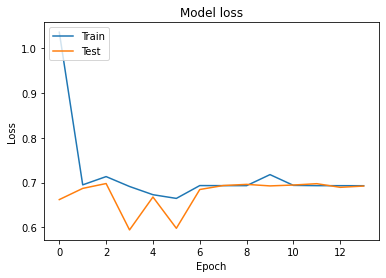

Fold 4:
Epoch 1/50
512/512 [==============================] - 6s 11ms/step - loss: 1.4074 - accuracy: 0.5526 - val_loss: 0.7006 - val_accuracy: 0.4936
Epoch 2/50
512/512 [==============================] - 5s 11ms/step - loss: 0.6809 - accuracy: 0.6507 - val_loss: 0.6085 - val_accuracy: 0.8007
Epoch 3/50
512/512 [==============================] - 5s 10ms/step - loss: 0.6483 - accuracy: 0.7178 - val_loss: 0.7253 - val_accuracy: 0.5780
Epoch 4/50
512/512 [==============================] - 5s 10ms/step - loss: 0.6321 - accuracy: 0.7384 - val_loss: 0.7150 - val_accuracy: 0.7293
Epoch 5/50
512/512 [==============================] - 5s 10ms/step - loss: 0.6005 - accuracy: 0.7635 - val_loss: 0.5651 - val_accuracy: 0.8276
Epoch 6/50
512/512 [==============================] - 6s 12ms/step - loss: 0.5978 - accuracy: 0.7618 - val_loss: 0.5233 - val_accuracy: 0.8232
Epoch 7/50
512/512 [==============================] - 5s 11ms/step - loss: 0.5831 - accuracy: 0.7821 - val_loss: 0.6367 - val_accuracy

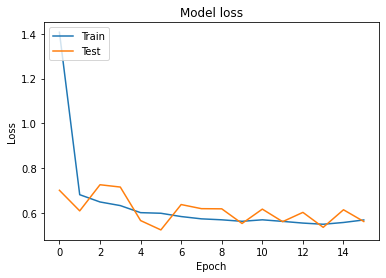

------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 0.64 - Accuracy: 54.46%
> Fold 2 - Loss: 0.65 - Accuracy: 82.33%
> Fold 3 - Loss: 0.65 - Accuracy: 66.38%
> Fold 4 - Loss: 0.69 - Accuracy: 80.62%
> Fold 5 - Loss: 0.56 - Accuracy: 82.21%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 73.20 (+- 11.11)
------------------------------------------------------------------------
Total Training time = 0:12:35 HH:MM:SS


In [18]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
y_pred_per_fold = []
y_valid_per_fold = []

skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

start_time = time.time()

for i, (train_index, valid_index) in enumerate(skf.split(X, y[:,0], groups=sub)):
        print(f"Fold {i}:")
        #print(len(train_index), train_index)
        #print(len(valid_index), valid_index)

        # More complicated with dictionary of multiple inputs.
        # iterate through all keys and add the proper index array

        X_train_dict = {}
        X_valid_dict = {}
        y_train_dict = {}
        y_valid_dict = {}

        for key,item in X_all_dict.items():
            X_train_dict[key] = item[train_index]
            X_valid_dict[key] = item[valid_index]
        for key,item in y_all_dict.items():
            y_train_dict[key] = item[train_index]
            y_valid_dict[key] = item[valid_index]
        
        # for key,item in X_train_dict.items():
        #     print(key,item.shape)
        # for key,item in y_train_dict.items():
        #     print(key,item.shape)
        # for key,item in X_valid_dict.items():
        #     print(key,item.shape)
        # for key,item in y_valid_dict.items():
        #     print(key,item.shape)

        # TODO:  Move one-hot into model
        enc = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
        y_train_card = enc.fit_transform(y_train_dict['card'])
        y_valid_card = enc.transform(y_valid_dict['card'])

        y_train_resp = enc.fit_transform(y_train_dict['resp'])
        y_valid_resp = enc.transform(y_valid_dict['resp'])

        # print(y_train_resp.shape)
        # print(y_valid_resp.shape)

        my_model = build_model(X_train_dict, y_train_dict)
        history, model = train_model(my_model, X_train_dict, y_train_card, X_valid_dict, y_valid_card)

        val_acc = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1] 

        acc_per_fold.append(val_acc * 100)
        loss_per_fold.append(val_loss)
                
        # Generate predictions
        y_pred = model.predict(X_valid_dict)

        y_pred = np.argmax(y_pred, axis=1)
        y_pred_per_fold.append(y_pred)
        y_valid_per_fold.append(np.argmax(y_valid_card, axis=1))

        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
#     print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:4.2} - Accuracy: {acc_per_fold[i]:4.2f}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold):4.2f} (+- {np.std(acc_per_fold):5.4})')
acc_str = temp = str(f'> Accuracy: {np.mean(acc_per_fold):4.2f} (+- {np.std(acc_per_fold):5.4})')
print('------------------------------------------------------------------------')

# Show total training time
end_time = time.time()
train_time = timedelta(seconds=(end_time - start_time))
print('Total Training time =',(str(train_time).split(".")[0]), 'HH:MM:SS')
# to plot confusion matrices return concat versions of y
y_pred = np.concatenate(y_pred_per_fold)
y_valid = np.concatenate(y_valid_per_fold)
#return acc_str, y_pred, y_test

              precision    recall  f1-score   support

           0       0.89      0.80      0.84     37157
           1       0.17      0.30      0.22      5176

    accuracy                           0.74     42333
   macro avg       0.53      0.55      0.53     42333
weighted avg       0.80      0.74      0.77     42333

Normalized confusion matrix
[[0.8 0.2]
 [0.7 0.3]]


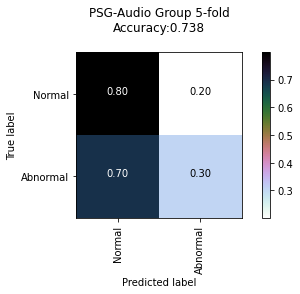

In [19]:
# == Confusion matrix ==
from sklearn.metrics import confusion_matrix
import itertools

# print(classification_report(y_test, y_pred, target_names=class_names))
print(classification_report(y_valid, y_pred))

cm = confusion_matrix(y_valid, y_pred)

def plot_confusion_matrix(cm, classes,
                            normalize=True,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
            print(np.array(cm).round(2)) # to limit digits
        else:
            print('Confusion matrix, without normalization')
            print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes,rotation=90)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
title = 'PSG-Audio Group 5-fold\n'
#title += "Predicting " + labels + " using " + ch_group + '\n'
title += 'Accuracy:{0:.3f}'.format(accuracy_score(y_valid, y_pred))+'\n'
class_names = ['Normal','Abnormal'] # cardiac events
plot_confusion_matrix(cm, classes=class_names, title=title, cmap='cubehelix_r')

# STOP - the following code is to load the data from and save figures to google drive.
You are welcome to use it, but it is untested outside of my environment.

In [ ]:
def get_load_data_utils():
    """checks for local file, if none downloads from IMICS repository.
    Assumes a global my_dir has been defined (default is my_dir = ".")
    :return: nothing"""
    fname = 'load_data_utils.py'
    ffname = os.path.join(my_dir,fname)
    if (os.path.exists(ffname)):
        print ("Local load_data_utils.py found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve("https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py", filename=fname)
if interactive:
    get_load_data_utils()

In [ ]:
from load_data_utils import get_env_info
from load_data_utils import get_log_ffname
from load_data_utils import tabulate_numpy_arrays
from load_data_utils import channel_powerset
if interactive:
    print('My env_info: \n' + get_env_info())

My env_info: 
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: name, driver_version, memory.total [MiB]
Tesla T4, 510.47.03, 15360 MiB



In [ ]:
save_log = False # set to False to avoid a problem if accidentally run...
# alternate confusion matrix with fig object to save
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                    index = class_names, 
                    columns = class_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
#plt.title('Insert title here\n
#plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()
if save_log:
    log_ffname = get_log_ffname(
    log_file_dir = '/content/drive/My Drive/Colab_Run_Results',
    base_fname = "PSG_Multi_Output_Work")
    print("Saving results to", log_ffname)
    with open(log_ffname, "a") as file_object:
        file_object.write("Generated by Evaluate_Model_PSG-Audio.ipynb\n")
        file_object.write("Processed PSG with 5 fold via sklearn GroupKFold\n")
        file_object.write("Final Accuracy: %0.3f\n" %accuracy_score(y_test, y_pred))
        file_object.write("Classification Report\n")
        file_object.write(classification_report(y_test, y_pred, target_names=class_names))
        file_object.write("Confusion Matrix\n")
        file_object.write(str(cm))
    cm_ffname = log_ffname.split('.')[0] + '_cm.pdf'
    print("saving cm plot as",cm_ffname)
    fig.savefig(cm_ffname,format='pdf', dpi=1200)
    full_model_fname = log_ffname.split('.')[0] + '_model.txt'
    with open(full_model_fname, "a") as file_object:
        model.summary(print_fn=lambda x: file_object.write(x + '\n'))
        #acknowledgement https://stackoverflow.com/users/14951382/sparklingdew
    #plot using keras function
    #ref https://keras.io/api/utils/model_plotting_utils/
    full_mplot_fname = log_ffname.split('.')[0] + '_model.png'
    keras.utils.plot_model(model, to_file=full_mplot_fname, show_shapes=True)